Idea: Show the tradeoffs between explicitly depending on (+ profiling) and removing dependence on a given systematic uncertainty using the ideas from [1601.07913](https://arxiv.org/pdf/1601.07913.pdf) and [1611.01046](https://arxiv.org/pdf/1611.01046.pdf) (code is [here](https://github.com/glouppe/paper-learning-to-pivot/blob/master/code/Toy.ipynb)).

In [1]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Dense, Lambda
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


First, let's generate some toy data.

In [154]:
N = 10000
N2 = int(N/2)
sigma = 0.25
signals = {}
backgrounds = {}
signal_tot = []
background_tot = []
means = [0,0.5,1,1.5,2]
for mean in means:
    signal = list(zip(np.random.normal(-mean,sigma,N2),mean*np.ones(N2)))
    signal += list(zip(np.random.normal(mean,sigma,N2),mean*np.ones(N2)))
    background = list(zip(np.random.normal(0,sigma,N),mean*np.ones(N)))
    #signals[mean]=np.random.normal(-mean,sigma,N2)
    signals[mean]=np.concatenate((np.random.normal(-mean,sigma,N2),np.random.normal(mean,sigma,N2)))
    backgrounds[mean]=np.random.normal(0,sigma,N)
    if (len(signal_tot) > 0):
        signal_tot = np.concatenate((signal_tot,signal))
        background_tot = np.concatenate((background_tot,background))
    else:
        signal_tot = signal
        background_tot = background
        pass
    pass

In [2]:
N = 100000
sigma = 0.25
signals = {}
backgrounds = {}
signal_tot = []
background_tot = []
means = [1.,0.8,0.6,0.4,0.2]
for mean in means:
    signal = list(zip(np.random.normal(0,sigma,int(N*mean)),mean*np.ones(int(N*mean))))
    signal += list(zip(np.random.uniform(-2,2,int(N*(1-mean))),mean*np.ones(int(N*(1-mean)))))
    background = list(zip(np.random.uniform(-2,2,N),mean*np.ones(N)))
    signals[mean]=np.concatenate((np.random.normal(0,sigma,int(N*mean)),np.random.uniform(-2,2,int(N*(1-mean)))))
    backgrounds[mean]=np.random.uniform(-2,2,N)
    if (len(signal_tot) > 0):
        signal_tot = np.concatenate((signal_tot,signal))
        background_tot = np.concatenate((background_tot,background))
    else:
        signal_tot = signal
        background_tot = background
        pass
    pass

(array([0.2474521 , 0.25709975, 0.25730502, 0.26582369, 0.25904981,
        0.24796527, 0.26551579, 0.2474521 , 0.24858108, 0.26489998,
        0.25915244, 0.25904981, 0.2534049 , 0.25792083, 0.253097  ,
        0.25094167, 0.25237856, 0.24693892, 0.26305256, 0.25658658,
        0.24909425, 0.25196802, 0.25997352, 0.25617604, 0.2634631 ,
        0.25771556, 0.26182094, 0.25453388, 0.25627867, 0.25207065,
        0.26192358, 0.25894717, 0.2554576 , 0.26089723, 0.25319963,
        0.26479735, 0.2554576 , 0.25904981, 0.25350754]),
 array([-2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
        -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
        -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01,
        -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
        -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
         1.77635684e-15,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
         4

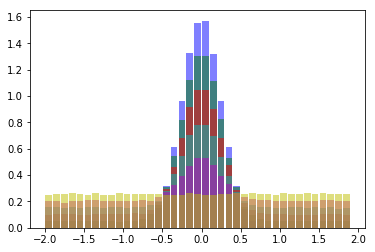

In [316]:
colors=['b','g','r','c','m']
for i in range(len(signals)):
    plt.hist(signals[means[i]], bins=np.arange(-2,2,0.1), color=colors[i], alpha=0.5, rwidth=0.85, density = True)
    pass
plt.hist(backgrounds[0.2], bins=np.arange(-2,2,0.1), color='y', alpha=0.5, rwidth=0.85, density = True)

In [3]:
# create model
model = Sequential()
model.add(Dense(12, input_dim=2, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [4]:
signal_labels = np.ones(len(signal_tot))
background_labels = np.zeros(len(background_tot))
X = np.concatenate((signal_tot, background_tot))
Y = np.concatenate((signal_labels, background_labels))

In [5]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
# Fit the model
model.fit(X, Y, epochs=2, batch_size=10)

Epoch 1/2
999999/999999 [==============================] - 207s 207us/step - loss: 0.5595 - acc: 0.7084
Epoch 2/2
999999/999999 [==============================] - 184s 184us/step - loss: 0.5561 - acc: 0.7092


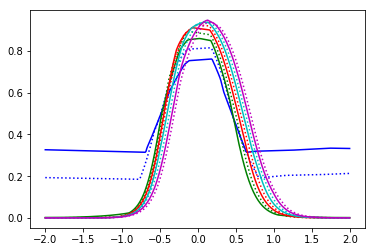

In [7]:
start =-2
xvals = []
while start < 2:
    xvals+=[start]
    start+=0.01
    pass
fig, ax = plt.subplots()
colors=['b','b','g','g','r','r','c','c','m','m']
means2 = [0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75]
for i in range(len(means2)):
    xvals2 = list(zip(xvals,means2[i]*np.ones(len(xvals))))
    np.shape(xvals2)
    NNoutput = model.predict(np.array(xvals2))
    if (i%2==1):
        ax.plot(xvals, NNoutput,color=colors[i],linestyle=':')
    else:
        ax.plot(xvals, NNoutput,color=colors[i])
        pass
    pass

Now, let's try with an adversary.

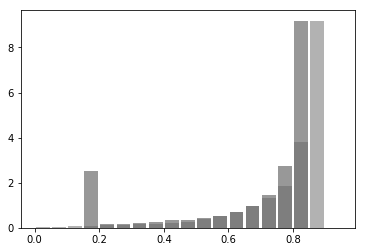

In [18]:
colors=['0.2','0.4','0.6','0.8','1.0']
means = [0.8,1.]
for j in range(len(means)):
    mean = means[j]
    vals=[]
    for i in range(len(signal_tot)):
        if (signal_tot[i][1]==mean):
            vals+=[signal_tot[i][0]]
            pass
        pass
    vals2 = list(zip(vals,mean*np.ones(len(vals))))
    predictions = model.predict(np.array(vals2))
    plt.hist(predictions, bins=np.arange(0,1,0.05), color=colors[j], alpha=0.5, rwidth=0.85, density = True)

Note: we will have a prior on the nuisance parameter and probably we will want to weight the training samples so that their contribution the loss is proportional to this prior weight (otherwise, the adversary will too harshly penalize extreme examples of the nuisance parameter!)

In [27]:
classifier_input = Input((2,))
classifier_net = Dense(10,activation='relu')(classifier_input)
classifier_output = Dense(1,activation='sigmoid')(classifier_net)

adversary_input = Input((10,))
adversary_net = Dense(20)(adversary_input)
adversary_output = Dense(1)(adversary_net)

aux_output = Model(classifier_input, classifier_net)

In [32]:
adversary_model = Model(adversary_input, adversary_output)
train_classifier_model = Model(
    classifier_input, 
    [classifier_output,adversary_model(aux_output(classifier_input))]
)
train_adversary_model = Model(
    classifier_input, 
    adversary_model(aux_output(classifier_input))
)

In [34]:
for layer_index, layer in enumerate(train_classifier_model.layers):
    layer.trainable = layer_index < 3

In [35]:
train_classifier_model.compile('Adam', loss=['binary_crossentropy','mse'], loss_weights=[1,-1])  

In [23]:
for layer_index, layer in enumerate(train_adversary_model.layers):
    layer.trainable = layer_index >= 3

In [24]:
train_adversary_model.compile('Adam', loss='mse')

In [33]:
train_classifier_model.summary()
train_adversary_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 10)           30          input_2[0][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 10)           30          input_2[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1)            11          dense_8[0][0]                    
__________________________________________________________________________________________________
model_11 (

In [314]:
predictions = np.ones(len(X))
for i in range(1):
    auto_input = X
    train_autoencoder_model.fit(X, [Y,predictions], epochs=1, batch_size=10) 

Epoch 1/1
100000/100000 [==============================] - 25s 248us/step - loss: -0.3784 - dense_55_loss: 0.2521 - dense_57_loss: 0.6305


In [315]:
predictions = train_autoencoder_model.predict(X)

In [316]:
fpr, tpr, _ = roc_curve(Y, predictions)

ValueError: Found input variables with inconsistent numbers of samples: [100000, 2]

In [ ]:
plt.plot(fpr, tpr, color='black')

In [15]:
predictions = model.predict(X)

In [16]:
Q=[x[1] for x in X]

In [203]:
model2 = Sequential()
model2.add(Dense(12, input_dim=1, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(predictions, Q, epochs=2, batch_size=10)

Epoch 1/2
100000/100000 [==============================] - 24s 243us/step - loss: 0.5800 - acc: 0.0000e+00
Epoch 2/2
100000/100000 [==============================] - 23s 230us/step - loss: 0.5725 - acc: 0.0000e+00


In [47]:
predictions2 = model2.predict(predictions)

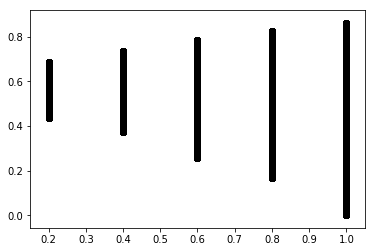

In [17]:
plt.scatter(Q, predictions, color='black')

In [67]:
signal_tot[len(signal_tot)-100:len(signal_tot)-1]

array([[2.08864456, 2.        ],
       [2.04732793, 2.        ],
       [2.00353825, 2.        ],
       [2.03120111, 2.        ],
       [2.0986137 , 2.        ],
       [2.01158578, 2.        ],
       [2.04423439, 2.        ],
       [2.05681363, 2.        ],
       [2.05643823, 2.        ],
       [2.09900995, 2.        ],
       [2.04191169, 2.        ],
       [2.03722017, 2.        ],
       [2.05755855, 2.        ],
       [2.00996916, 2.        ],
       [2.08597499, 2.        ],
       [2.0420167 , 2.        ],
       [2.09077174, 2.        ],
       [2.0022047 , 2.        ],
       [2.01107643, 2.        ],
       [2.06333735, 2.        ],
       [2.07849265, 2.        ],
       [2.06599844, 2.        ],
       [2.0665012 , 2.        ],
       [2.00654708, 2.        ],
       [2.07901826, 2.        ],
       [2.05325539, 2.        ],
       [2.08387296, 2.        ],
       [2.04034548, 2.        ],
       [2.0849432 , 2.        ],
       [2.05865418, 2.        ],
       [2.

For fun, let's try the example from the pivot paper.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 16.0

import numpy as np
np.random.seed = 333

In [3]:
from carl.distributions import Mixture, MultivariateNormal, Uniform, Normal

p0 = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.array([[1., -0.5], [-0.5, 1.]]))
p1 = MultivariateNormal(mu=np.array([1., 1.]), sigma=np.eye(2))
pz = Normal(mu=0.0, sigma=1.0)

In [4]:
n_samples = 125000

X0 = p0.rvs(n_samples // 2)
X1 = p1.rvs(n_samples // 2)
z = pz.rvs(n_samples).ravel()
X1[:, 1] += z[n_samples // 2:]

X = np.vstack([X0, X1])
y = np.zeros(n_samples)
y[n_samples // 2:] = 1

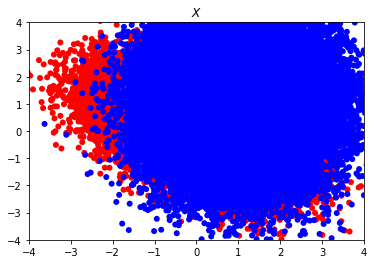

In [5]:
plt.title("$X$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [6]:
from sklearn.cross_validation import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=50000)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
import keras.backend as K
from keras.layers import Input, Dense, Merge, Lambda
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

n_components = 5
Rx = D(inputs)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(20, activation="relu")(Rx)
mu = Dense(n_components, activation="linear")(Rx)
sigma = Dense(n_components, activation=K.exp)(Rx)
pi = Dense(n_components, activation="softmax")(Rx)
Rx = Merge(mode="concat")([mu, sigma, pi])

R = Model(input=[inputs], output=[Rx])

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ImportError: cannot import name 'Merge'